In [104]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import mixture
from sklearn.cluster import KMeans

In [79]:
X_, Y_ = np.s_[:,0], np.s_[:,1]

In [130]:
df = pd.read_csv('data_for_gmm.csv')
df.head()

,x,y,Class
0,0.359955,0.905790,C1
1,0.333131,0.896499,C1
2,0.355769,0.879772,C1
3,0.340103,0.908589,C1
4,0.352423,0.880319,C1


In [131]:
warnings.filterwarnings('ignore')
examples = df[['x', 'y']][2:].convert_objects(convert_numeric=True).to_numpy()

In [132]:
labels = df['Class'][2:].to_numpy()
labels[np.where(labels == 'C1')[0]] = 1
labels[np.where(labels == 'C2')[0]] = 2
labels[np.where(labels == 'C3')[0]] = 3
labels[np.where(labels == 'C4')[0]] = 4
labels = np.array(labels, dtype=int)

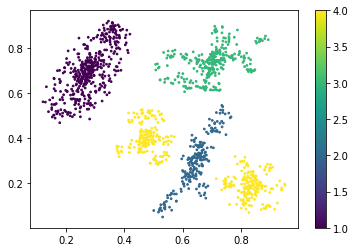

In [133]:
plt.scatter(examples[X_], examples[Y_], c=labels, s=3)
plt.colorbar()
plt.show()

In [195]:
clf = mixture.GaussianMixture(n_components=5, covariance_type='full', n_init=5) 
# by default, init_params='kmeans', see below
# increase n_init increases kmeans performance
clf.fit(examples)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=5, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [196]:
X = np.linspace(0, 1, 200)
Y = np.linspace(0, 1, 200)
XXS, YYS = np.meshgrid(X, Y)
grid = np.hstack([XXS.flatten().reshape(-1, 1), YYS.flatten().reshape(-1, 1)])
grid_values = np.sum(np.exp(clf._estimate_weighted_log_prob(grid)), axis=1)
# the posterior probabilities computed by clf.predict_proba(grid) are normalized

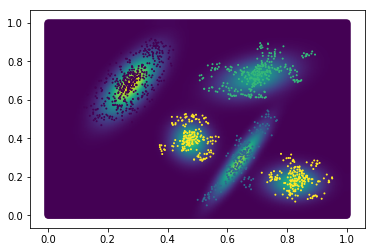

In [197]:
plt.scatter(grid[X_], grid[Y_], c=grid_values, cmap='viridis', alpha=1)
plt.scatter(examples[X_], examples[Y_], c=labels, s=1)
plt.show()

## Compute second-layer weights

In [209]:
PHI = np.exp(clf._estimate_log_prob(examples))
T = labels.reshape(-1, 1)
PHI.shape, T.shape

((1342, 5), (1342, 1))

In [210]:
W2 = np.linalg.inv(PHI.T @ PHI) @ PHI.T @ T  # solution to linear least squares

In [216]:
OUT = (PHI @ W2)  # equivalent to discarding the component weights learned by EM for GMM
OUT.shape

(1342, 1)

In [217]:
grid_PHI = np.exp(clf._estimate_log_prob(grid))
grid_OUT = (grid_PHI @ W2).reshape(200, 200)
grid_PHI.shape, grid_OUT.shape

((40000, 5), (200, 200))

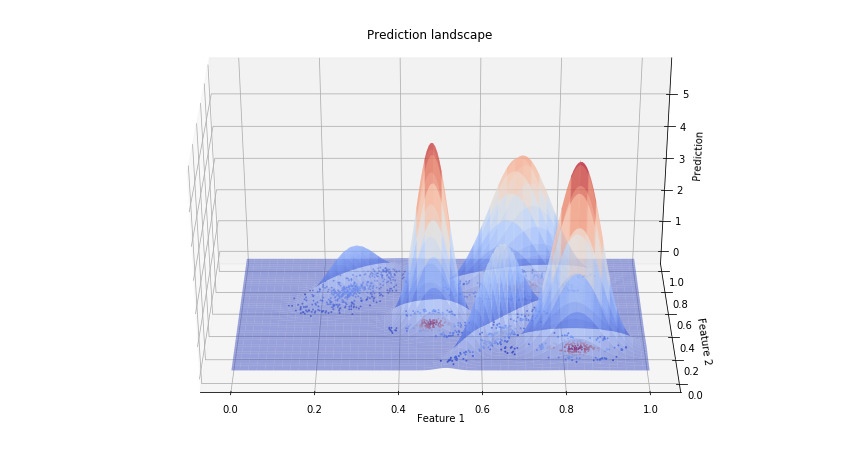

In [218]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
# plt.scatter(examples[X_], examples[Y_], c=(PHI @ W2).flatten())
plt.scatter(examples[X_], examples[Y_], c=OUT.flatten(), cmap='coolwarm', s=1)
ax.plot_surface(XXS, YYS, grid_OUT, cmap='coolwarm', alpha=0.5)
ax.view_init(30, -90)
ax.set_title('Prediction landscape')
ax.set_xlabel('Feature 1'); ax.set_ylabel('Feature 2'); ax.set_zlabel('Prediction')
plt.show()